In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import structureboost as stb
import ml_insights as mli

from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',999)

In [2]:
# Implemented directly due to sklearn problem if all classes
# not represented in test set

def log_loss(y_true, y_pred, eps=1e-16):
    y_pred = np.clip(y_pred, eps, (1-eps))
    prob_of_truth = np.array([y_pred[i,y_true[i]] for i in range(len(y_true))])
    out_val = -np.mean(np.log(prob_of_truth))
    return out_val

In [3]:
df_both = pd.read_csv('df_both.csv')

In [4]:
df_both.head()

,county,month,DATE,STATION,PRCP,rained,TMAX,TMIN,outcome,county_num
0,Alameda,1,2000-01-01,USW00023285,0.00,0,53.0,40.0,1,0
1,Alameda,1,2000-01-02,USW00023285,0.00,0,56.0,27.0,1,0
2,Alameda,1,2000-01-03,USW00023285,0.00,0,56.0,30.0,1,0
3,Alameda,1,2000-01-04,USW00023285,0.01,1,58.0,32.0,1,0
4,Alameda,1,2000-01-05,USW00023285,0.00,0,61.0,41.0,1,0


In [5]:
df_both.shape

(2438258, 10)

In [6]:
feat_set = ['PRCP', 'TMAX', 'TMIN']

target_var = 'county_num'

In [7]:
# Yuba and Sutter share county facilities
ca_county_graph_str = stb.graphs.CA_county_graph()
ca_county_graph_str = ca_county_graph_str.contract_edge(['Yuba','Sutter'])

In [8]:
# Create mapping from county names to county nums 
# so that graph uses integers to represent counties
map_dict = {cn: df_both.county_num[df_both.county==cn].iloc[0] 
            for cn in df_both.county.unique()}
map_dict['Sutter_Yuba'] = map_dict['Yuba']

ca_county_graph = stb.graphs.integerize_graph_from_dict(ca_county_graph_str, map_dict)

In [9]:
train_size_vec = [500, 1000, 2000, 5000, 10000, 20000]
md_range = [2,3,4]
num_trials = 5
valid_size = 5000
test_size = 25000
llmat_str0 = np.zeros((len(train_size_vec), num_trials, len(md_range)))
llmat_str1 = np.zeros((len(train_size_vec), num_trials, len(md_range)))
llmat_str2 = np.zeros((len(train_size_vec), num_trials, len(md_range)))
llmat_str3 = np.zeros((len(train_size_vec), num_trials, len(md_range)))
llmat_str2a = np.zeros((len(train_size_vec), num_trials, len(md_range)))
llmat_str2b = np.zeros((len(train_size_vec), num_trials, len(md_range)))


for i,train_size in enumerate(train_size_vec):   
    for j in range(num_trials):
        print('train_size {}'.format(train_size))
        print('trial num {}'.format(j))
        df_small = df_both.sample(test_size+valid_size+train_size, random_state=j).reset_index(drop=True).copy()
        X = df_small.loc[:,feat_set].copy()
        y = df_small[target_var].copy().values
        X_train_val, X_test, y_train_val, y_test = train_test_split(X,y,test_size=test_size, random_state=j)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=j)
        X_train.shape, X_valid.shape, X_test.shape
        
        fc1 = stb.get_basic_config(X_train, stb.default_config_dict())
        ts1 = {}
        ts1['singleton_weight'] = .5
        ts1['partition_list'] = 'random'
        ts1['random_partition_size'] = 5
        ts1['target_graph']= ca_county_graph
        
        ts2 = {}
        ts2['singleton_weight'] = .5
        ts2['random_partition_size'] = 10
        ts2['partition_list'] = 'random'
        ts2['target_graph']= ca_county_graph

        ts3 = {}
        ts3['singleton_weight'] = .5
        ts3['random_partition_size'] = 20
        ts3['partition_list'] = 'random'
        ts3['target_graph']= ca_county_graph

        ts2a = {}
        ts2a['singleton_weight'] = .25
        ts2a['random_partition_size'] = 10
        ts2a['partition_list'] = 'random'
        ts2a['target_graph']= ca_county_graph

        ts2b = {}
        ts2b['singleton_weight'] = .75
        ts2b['random_partition_size'] = 10
        ts2b['partition_list'] = 'random'
        ts2b['target_graph']= ca_county_graph

        for zzz,md in enumerate(md_range):
            gbmstr1 = stb.StructureBoostMulti(num_trees=5000, target_structure=ts1, learning_rate=.02,
                                          feature_configs=fc1, num_classes=58, max_depth=md)

            gbmstr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_freq=10, early_stop_past_steps=3)

            pred_probs_gbstr1 = gbmstr1.predict_proba(X_test)
            llmat_str1[i,j,zzz] = log_loss(y_test, pred_probs_gbstr1)
        print(llmat_str1[i,j,:])
        for zzz,md in enumerate(md_range):
            gbmstr2 = stb.StructureBoostMulti(num_trees=5000, target_structure=ts2, learning_rate=.02,
                                          feature_configs=fc1, num_classes=58, max_depth=md)

            gbmstr2.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_freq=10, early_stop_past_steps=3)

            pred_probs_gbstr2 = gbmstr2.predict_proba(X_test)
            llmat_str2[i,j,zzz] = log_loss(y_test, pred_probs_gbstr2)
        print(llmat_str2[i,j,:])
        for zzz,md in enumerate(md_range):
            gbmstr3 = stb.StructureBoostMulti(num_trees=5000, target_structure=ts3, learning_rate=.02,
                                          feature_configs=fc1, num_classes=58, max_depth=md)

            gbmstr3.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_freq=10, early_stop_past_steps=3)

            pred_probs_gbstr3 = gbmstr3.predict_proba(X_test)
            llmat_str3[i,j,zzz] = log_loss(y_test, pred_probs_gbstr3)
        print(llmat_str3[i,j,:])
        for zzz,md in enumerate(md_range):
            gbmstr0 = stb.StructureBoostMulti(num_trees=5000, learning_rate=.02,
                                          feature_configs=fc1, num_classes=58, max_depth=md)

            gbmstr0.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_freq=10, early_stop_past_steps=3)

            pred_probs_gbstr0 = gbmstr0.predict_proba(X_test)
            llmat_str0[i,j,zzz] = log_loss(y_test, pred_probs_gbstr0)  
        print(llmat_str0[i,j,:])    
        for zzz,md in enumerate(md_range):
            gbmstr2a = stb.StructureBoostMulti(num_trees=5000, target_structure=ts2a, learning_rate=.02,
                                          feature_configs=fc1, num_classes=58, max_depth=md)

            gbmstr2a.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_freq=10, early_stop_past_steps=3)

            pred_probs_gbstr2a = gbmstr2a.predict_proba(X_test)
            llmat_str2a[i,j,zzz] = log_loss(y_test, pred_probs_gbstr2a)
        print(llmat_str2a[i,j,:])
        for zzz,md in enumerate(md_range):
            gbmstr2b = stb.StructureBoostMulti(num_trees=5000, target_structure=ts2b, learning_rate=.02,
                                          feature_configs=fc1, num_classes=58, max_depth=md)

            gbmstr2b.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_freq=10, early_stop_past_steps=3)

            pred_probs_gbstr2b = gbmstr2b.predict_proba(X_test)
            llmat_str2b[i,j,zzz] = log_loss(y_test, pred_probs_gbstr2b)
        print(llmat_str2b[i,j,:])


train_size 500
trial num 0
random partition
i=0, eval_set_log_loss = 4.0168719556070736
i=10, eval_set_log_loss = 3.98442778100589
i=20, eval_set_log_loss = 3.9608030391143285
i=30, eval_set_log_loss = 3.939857037171314
i=40, eval_set_log_loss = 3.923243376008346
i=50, eval_set_log_loss = 3.9092024495080193
i=60, eval_set_log_loss = 3.896557928205032
i=70, eval_set_log_loss = 3.8880614669169655
i=80, eval_set_log_loss = 3.878635802522316
i=90, eval_set_log_loss = 3.8720686766823174
i=100, eval_set_log_loss = 3.867240470503668
i=110, eval_set_log_loss = 3.863336249339414
i=120, eval_set_log_loss = 3.858934423925417
i=130, eval_set_log_loss = 3.8559162662985633
i=140, eval_set_log_loss = 3.8532881405329724
i=150, eval_set_log_loss = 3.8517478393527154
i=160, eval_set_log_loss = 3.8494600868057254
i=170, eval_set_log_loss = 3.8472134190025185
i=180, eval_set_log_loss = 3.84511760338481
i=190, eval_set_log_loss = 3.8437601712406133
i=200, eval_set_log_loss = 3.8422563843730226
i=210, eval_

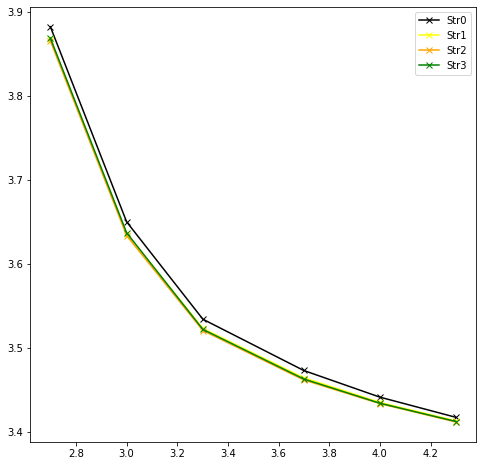

In [10]:
str0vec = np.min(np.mean(llmat_str0, axis=1), axis=1)
str1vec = np.min(np.mean(llmat_str1, axis=1), axis=1)
str2vec = np.min(np.mean(llmat_str2, axis=1), axis=1)
str3vec = np.min(np.mean(llmat_str3, axis=1), axis=1)
str2avec = np.min(np.mean(llmat_str2a, axis=1), axis=1)
str2bvec = np.min(np.mean(llmat_str2b, axis=1), axis=1)

best_md_str0 = np.argmin(np.mean(llmat_str0, axis=1),axis=1)+1
best_md_str1 = np.argmin(np.mean(llmat_str1, axis=1),axis=1)+1
best_md_str2 = np.argmin(np.mean(llmat_str2, axis=1),axis=1)+1
best_md_str3 = np.argmin(np.mean(llmat_str3, axis=1),axis=1)+1

plt.figure(figsize=(8,8))
plt.plot(np.log10(train_size_vec), str0vec, label='Str0', color='black', marker ='x')
plt.plot(np.log10(train_size_vec), str1vec, label='Str1',color='yellow', marker ='x')
plt.plot(np.log10(train_size_vec), str2vec, label='Str2', color='orange', marker ='x')
plt.plot(np.log10(train_size_vec), str3vec, label='Str3', color='green', marker ='x')
plt.legend()

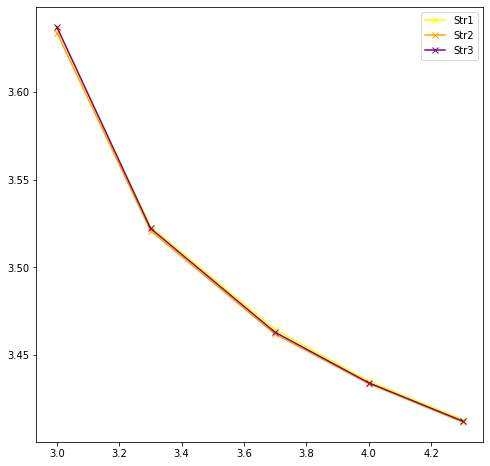

In [11]:
plt.figure(figsize=(8,8))
plt.plot(np.log10(train_size_vec[1:]), str1vec[1:], label='Str1',color='yellow', marker ='x')
plt.plot(np.log10(train_size_vec[1:]), str2vec[1:], label='Str2', color='orange', marker ='x')
plt.plot(np.log10(train_size_vec[1:]), str3vec[1:], label='Str3', color='purple', marker ='x')
plt.legend()

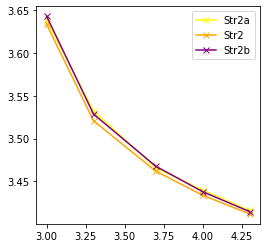

In [12]:
plt.figure(figsize=(4,4))
plt.plot(np.log10(train_size_vec[1:]), str2avec[1:], label='Str2a',color='yellow', marker ='x')
plt.plot(np.log10(train_size_vec[1:]), str2vec[1:], label='Str2', color='orange', marker ='x')
plt.plot(np.log10(train_size_vec[1:]), str2bvec[1:], label='Str2b', color='purple', marker ='x')
plt.legend()

In [13]:
np.vstack((best_md_str0.T, best_md_str1.T, best_md_str2.T, best_md_str3.T))

array([[1, 2, 2, 2, 2, 2],
       [1, 2, 1, 1, 2, 2],
       [1, 2, 2, 2, 2, 2],
       [1, 1, 2, 2, 2, 2]])

In [14]:
np.round(np.vstack((str2avec.T, str2vec.T, str2bvec.T, str0vec.T)),decimals=4)

array([[3.8645, 3.6389, 3.5323, 3.466 , 3.4397, 3.4159],
       [3.8657, 3.6338, 3.5208, 3.462 , 3.4337, 3.4118],
       [3.8757, 3.6431, 3.5286, 3.4677, 3.4379, 3.4145],
       [3.8826, 3.6502, 3.5343, 3.4732, 3.4414, 3.4173]])

In [15]:
np.round(np.vstack((str0vec.T, str1vec.T, str2vec.T, str3vec.T)),decimals=4)

array([[3.8826, 3.6502, 3.5343, 3.4732, 3.4414, 3.4173],
       [3.8679, 3.6363, 3.5232, 3.4646, 3.4352, 3.4132],
       [3.8657, 3.6338, 3.5208, 3.462 , 3.4337, 3.4118],
       [3.869 , 3.6372, 3.5221, 3.4631, 3.4342, 3.4124]])

In [16]:
np.save('llmat_str0.npy', llmat_str0)

In [17]:
np.save('llmat_str1.npy', llmat_str1)
np.save('llmat_str2.npy', llmat_str2)
np.save('llmat_str3.npy', llmat_str3)

In [18]:
np.save('llmat_str2a.npy', llmat_str2a)
np.save('llmat_str2b.npy', llmat_str2b)
